# EDA for Swimming Olympics Dataset

In [150]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [151]:
def top_ten_countries(df):
    # groupby country and count the number of medals
    country_medals = df.groupby('Country').size().reset_index(name='Medals')
    country_medals = country_medals.sort_values(by='Medals', ascending=False)
    # get the top 10 countries
    top_10_countries = country_medals.head(10)['Country'].values
    top_10_df = df[df['Country'].isin(top_10_countries)]
    year_country_medals = top_10_df.groupby(['Year', 'Country']).size().reset_index(name='Medals')
    
    return year_country_medals   


def get_potential_medals(df):
    # combine the category and event columns to get all the events by gender
    df['Cat_Event'] = df['Category'] + ' ' + df['Event']

    # calculate the number of potential medals based on the number of events
    n_events_df = df.groupby('Year')['Cat_Event'].nunique().reset_index(name='Events_Count')
    
    # potential medals
    n_events_df['Potential_Medals'] = n_events_df['Events_Count'] * 3
    
    return n_events_df

def get_pct_medals(df, potential_medals_df):
    # join the number of potential medals to the year_country_medals dataframe
    year_country_medals = df.join(potential_medals_df.set_index('Year'), on='Year')

    # calculate the percentage of medals won
    year_country_medals['Pct_Medals'] = year_country_medals['Medals'] / year_country_medals['Potential_Medals'] * 100
    year_country_medals['Pct_Medals'] = year_country_medals['Pct_Medals'].round(2)

    return year_country_medals

def pct_weighted_medals(df):
    """ 
    Add a value to each medal based on ordinal value.
    Scoring will be 1 for Bronze, 2 for Silver, 3 for Gold.
    Then produce the weighted percent of medal score achieved.
    """
    wt_pct_medals = df.copy()
    # assign wetights
    wt_pct_medals['wt_medal'] = wt_pct_medals['Medal'].map({"Gold":3, "Silver":2, "Bronze":1})
    # group by year to get potential total
    potential_medals = wt_pct_medals.groupby(['Year'])['wt_medal'].sum().reset_index(name='potential_medal_score')
    # group by year, country, and sum the weighted score
    wt_pct_medals = wt_pct_medals.groupby(['Year', 'Country'])['wt_medal'].sum().reset_index()
    # join with the potential medals
    wt_pct_medals = pd.merge(wt_pct_medals, potential_medals, how='left')
    # calculate the pct of medal score
    wt_pct_medals['Pct_Medal_Score'] = wt_pct_medals['wt_medal'] / wt_pct_medals['potential_medal_score']

    return wt_pct_medals[['Year', 'Country', 'Pct_Medal_Score']]
    

## Initial Statistics

In [152]:
swim_df = pd.read_csv('../data/processed/swimming/swimming_results.csv')

In [153]:
swim_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1908 entries, 0 to 1907
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Athlete   1908 non-null   object
 1   Country   1908 non-null   object
 2   NOC       1908 non-null   object
 3   Season    1908 non-null   object
 4   Year      1908 non-null   int64 
 5   City      1908 non-null   object
 6   Sport     1908 non-null   object
 7   Event     1908 non-null   object
 8   Medal     1908 non-null   object
 9   Category  1908 non-null   object
dtypes: int64(1), object(9)
memory usage: 149.2+ KB


In [154]:
print(f"Min Date: {swim_df['Year'].min()}")
print(f"Max Date: {swim_df['Year'].max()}")


Min Date: 1896
Max Date: 2024


In [155]:
# view the categorical columns summary statistics
swim_df[swim_df.dtypes[swim_df.dtypes == 'object'].index].describe()

,Athlete,Country,NOC,Season,City,Sport,Event,Medal,Category
count,1908,1908,1908,1908,1908,1908,1908,1908,1908
unique,990,61,57,1,23,1,57,3,3
top,United States,United States,USA,Summer,Paris,Swimming,100M Freestyle,Gold,Men
freq,104,608,611,1908,169,1908,160,637,1037


### Dataframe Statistics Summary

The data looks as expected.
- There are only three values for Medal (Gold, Silver, Bronze)
- There are only three values for Category (Men, Women, Mixed)
- There is only one Sport (Swimming)
- The  Athlete, Country, and Event count cannot be verified right now, but can be explored more.

## Analyze the Last 50 Years of Olympic Swimming

In [156]:
# filter by the year
recent_swim_df = swim_df[swim_df['Year'] >= 1974]

recent_swim_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1240 entries, 0 to 1907
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Athlete   1240 non-null   object
 1   Country   1240 non-null   object
 2   NOC       1240 non-null   object
 3   Season    1240 non-null   object
 4   Year      1240 non-null   int64 
 5   City      1240 non-null   object
 6   Sport     1240 non-null   object
 7   Event     1240 non-null   object
 8   Medal     1240 non-null   object
 9   Category  1240 non-null   object
dtypes: int64(1), object(9)
memory usage: 106.6+ KB


### View Medals by Country

In [157]:
# groupby country and count the number of medals
country_medals = recent_swim_df.groupby('Country').size().reset_index(name='Medals')
country_medals = country_medals.sort_values(by='Medals', ascending=False)
country_medals.head(10)

,Country,Medals
47,United States,353
1,Australia,155
13,East Germany,77
8,China,61
7,Canada,50
17,Great Britain,49
20,Hungary,46
23,Japan,41
38,Soviet Union,40
16,Germany,39


In [158]:
recent_swim_df = recent_swim_df.copy()

# replace East Germany with Germany
recent_swim_df.loc[recent_swim_df['Country'] == 'East Germany', 'Country'] = 'Germany'
# replace Soviet Union with Russia
recent_swim_df.loc[recent_swim_df['Country'] == 'Soviet Union', 'Country'] = 'Russia'

# groupby country and count the number of medals
country_medals = recent_swim_df.groupby('Country').size().reset_index(name='Medals')
country_medals = country_medals.sort_values(by='Medals', ascending=False)
country_medals.head(10) 


,Country,Medals
45,United States,353
1,Australia,155
15,Germany,116
30,Russia,68
8,China,61
7,Canada,50
16,Great Britain,49
19,Hungary,46
22,Japan,41
25,Netherlands,39


In [159]:
# get the top 10 countries
top_10_countries = country_medals.head(10)['Country'].values
top_10_countries

array(['United States', 'Australia', 'Germany', 'Russia', 'China',
       'Canada', 'Great Britain', 'Hungary', 'Japan', 'Netherlands'],
      dtype=object)

In [160]:
# group by year and country to get the number of medals
top_10_year_country_medals = recent_swim_df[recent_swim_df['Country'].isin(top_10_countries)].groupby(['Year', 'Country']).size().reset_index(name='Medals')
top_10_year_country_medals.head()

,Year,Country,Medals
0,1976,Australia,1
1,1976,Canada,8
2,1976,Germany,19
3,1976,Great Britain,3
4,1976,Netherlands,2


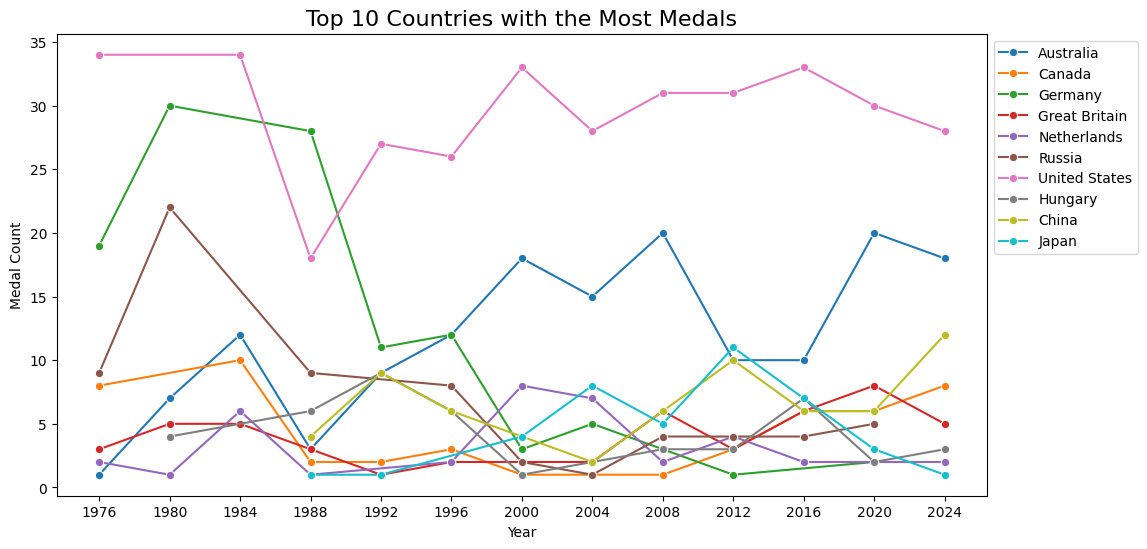

In [161]:
# plot the top 10 countries with the most medals over the years
plt.figure(figsize=(12, 6))
sns.lineplot(y='Medals', x='Year', data=top_10_year_country_medals, hue='Country', marker='o')
plt.title('Top 10 Countries with the Most Medals', fontsize=16)
plt.ylabel('Medal Count')
plt.xticks(np.arange(1976, 2025, 4))
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

In [162]:
top_10_year_country_medals[top_10_year_country_medals['Country'] == 'United States']

,Year,Country,Medals
6,1976,United States,34
17,1984,United States,34
27,1988,United States,18
35,1992,United States,27
44,1996,United States,26
52,2000,United States,33
61,2004,United States,28
71,2008,United States,31
81,2012,United States,31
90,2016,United States,33


### Create a Metric for the Percentage of Medals

In [163]:
# combine the category and event columns to get all the events by gender
recent_swim_df['Cat_Event'] = recent_swim_df['Category'] + ' ' + recent_swim_df['Event']

# calculate the number of potential medals based on the number of events
n_events_df = recent_swim_df.groupby('Year')['Cat_Event'].nunique().reset_index(name='Events_Count')
n_events_df.describe()

,Year,Events_Count
count,13.000000,13.000000
mean,2000.000000,31.615385
std,15.577762,3.042435
min,1976.000000,26.000000
25%,1988.000000,31.000000
50%,2000.000000,32.000000
75%,2012.000000,34.000000
max,2024.000000,35.000000


In [164]:
n_events_df

,Year,Events_Count
0,1976,26
1,1980,26
2,1984,29
3,1988,31
4,1992,31
5,1996,32
6,2000,32
7,2004,32
8,2008,34
9,2012,34


There are 9 more events for swimming in the recent Olympics compared to the 1976 Olympics.

What are the new events? Perform sanity check!!

In [165]:
# create a list of events from 1976
events_1976 = recent_swim_df[recent_swim_df['Year'] == 1976]['Cat_Event'].unique()

# view the events in 2024 that were not in 1976
events_2024 = recent_swim_df[recent_swim_df['Year'] == 2024]['Cat_Event'].unique()
new_events = [event for event in events_2024 if event not in events_1976]

print("The events in 2024 that were not in 1976 are:")
new_events

The events in 2024 that were not in 1976 are:


['Women 50M Freestyle',
 'Women 200M Individual Medley',
 'Men 200M Individual Medley',
 'Men 50M Freestyle',
 'Women 1500M Freestyle',
 'Men 800M Freestyle',
 'Men 4X100M Freestyle Relay',
 'Mixed  4X100M Medley Relay',
 'Women 4X200M Freestyle Relay']

Doing a search of the Olympics website for the results from 1976, it can be confirmed that these events were not in the 1976 Olympics.

In [166]:
# create a number of potential medals column
n_events_df['Potential_Medals'] = n_events_df['Events_Count'] * 3
n_events_df

,Year,Events_Count,Potential_Medals
0,1976,26,78
1,1980,26,78
2,1984,29,87
3,1988,31,93
4,1992,31,93
5,1996,32,96
6,2000,32,96
7,2004,32,96
8,2008,34,102
9,2012,34,102


There are 27 more potential medals in 2024 than in 1976!!!

In [167]:
# join the number of potential medals to the year_country_medals dataframe
top_10_year_country_medals = top_10_year_country_medals.join(n_events_df.set_index('Year'), on='Year')

# calculate the percentage of medals won
top_10_year_country_medals['Pct_Medals'] = top_10_year_country_medals['Medals'] / top_10_year_country_medals['Potential_Medals'] * 100
top_10_year_country_medals['Pct_Medals'] = top_10_year_country_medals['Pct_Medals'].round(2)

In [168]:
top_10_year_country_medals.head()

,Year,Country,Medals,Events_Count,Potential_Medals,Pct_Medals
0,1976,Australia,1,26,78,1.28
1,1976,Canada,8,26,78,10.26
2,1976,Germany,19,26,78,24.36
3,1976,Great Britain,3,26,78,3.85
4,1976,Netherlands,2,26,78,2.56


In [169]:
# assert the that grouped percentage of medals won is less than or equal to 100
top_10_year_country_medals.groupby('Year')['Pct_Medals'].sum()

Year
1976    97.44
1980    88.46
1984    77.01
1988    80.66
1992    74.21
1996    80.19
2000    72.91
2004    72.90
2008    79.40
2012    78.41
2016    79.39
2020    79.98
2024    75.23
Name: Pct_Medals, dtype: float64

The top ten countries usually make up 70-80% of the medal count. The exception is 1976 and 1980.

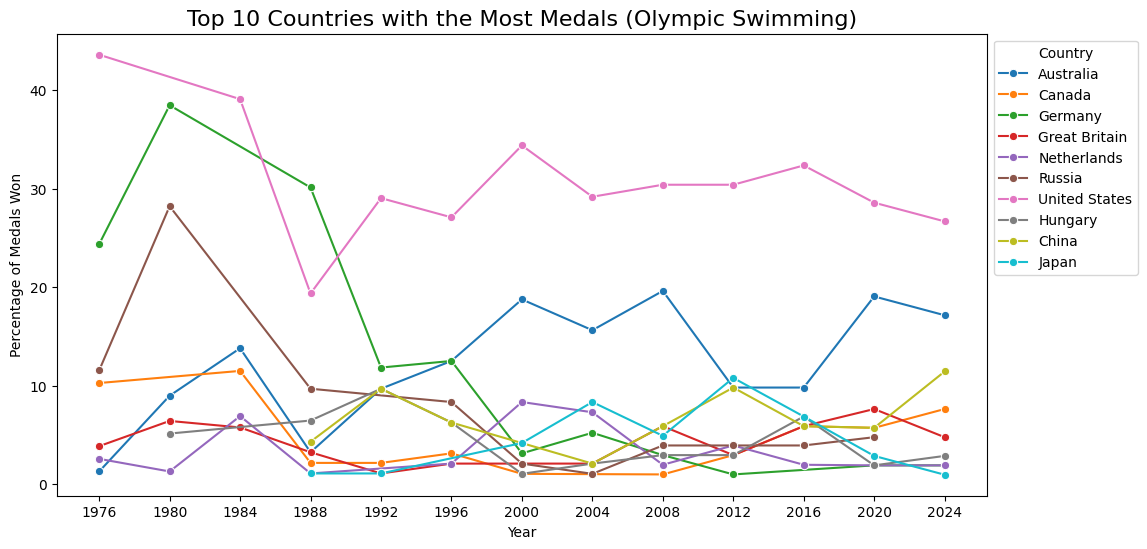

In [170]:
pct_top_ten_df = top_10_year_country_medals[top_10_year_country_medals['Country'].isin(top_10_countries)]

# plot the top 10 countries with the most medals over the years
plt.figure(figsize=(12, 6))
sns.lineplot(y='Pct_Medals', x='Year', data=pct_top_ten_df, hue='Country', marker='o')
plt.title('Top 10 Countries with the Most Medals (Olympic Swimming)', fontsize=16)
plt.xlabel('Year')
plt.ylabel('Percentage of Medals Won')
plt.legend(title='Country', bbox_to_anchor=(1, 1))
plt.xticks(np.arange(1976, 2025, 4))
plt.show()

### View Results by Gender

In [171]:
recent_swim_df['Category'].value_counts()

Men      621
Women    613
Mixed      6
Name: Category, dtype: int64

In [172]:
# split the df by gender
men_swim_df = recent_swim_df[recent_swim_df['Category'] == 'Men']
women_swim_df = recent_swim_df[recent_swim_df['Category'] == 'Women']

In [173]:
def top_ten_countries(df):
    # groupby country and count the number of medals
    country_medals = df.groupby('Country').size().reset_index(name='Medals')
    country_medals = country_medals.sort_values(by='Medals', ascending=False)
    # get the top 10 countries
    top_10_countries = country_medals.head(10)['Country'].values
    top_10_df = df[df['Country'].isin(top_10_countries)]
    year_country_medals = top_10_df.groupby(['Year', 'Country']).size().reset_index(name='Medals')
    
    return year_country_medals   


def get_potential_medals(df):
    # combine the category and event columns to get all the events by gender
    df['Cat_Event'] = df['Category'] + ' ' + df['Event']

    # calculate the number of potential medals based on the number of events
    n_events_df = df.groupby('Year')['Cat_Event'].nunique().reset_index(name='Events_Count')
    
    # potential medals
    n_events_df['Potential_Medals'] = n_events_df['Events_Count'] * 3
    
    return n_events_df

def get_pct_medals(df, potential_medals_df):
    # join the number of potential medals to the year_country_medals dataframe
    year_country_medals = df.join(potential_medals_df.set_index('Year'), on='Year')

    # calculate the percentage of medals won
    year_country_medals['Pct_Medals'] = year_country_medals['Medals'] / year_country_medals['Potential_Medals'] * 100
    year_country_medals['Pct_Medals'] = year_country_medals['Pct_Medals'].round(2)

    return year_country_medals

C:\Users\dagar\AppData\Local\Temp\ipykernel_31240\1415357752.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Cat_Event'] = df['Category'] + ' ' + df['Event']


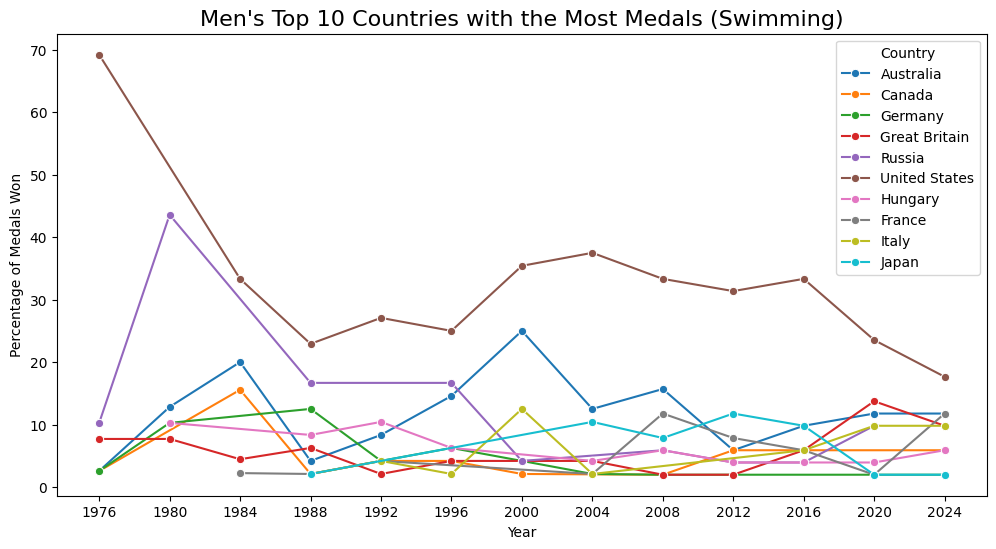

In [174]:
men_top_ten_df = top_ten_countries(men_swim_df)
potential_medals_df = get_potential_medals(men_swim_df)
men_pct_medals_df = get_pct_medals(men_top_ten_df, potential_medals_df)

# plot the top 10 countries with the most medals over the years
plt.figure(figsize=(12, 6))
sns.lineplot(y='Pct_Medals', x='Year', data=men_pct_medals_df, hue='Country', marker='o')
plt.title('Men\'s Top 10 Countries with the Most Medals (Swimming)', fontsize=16)
plt.xlabel('Year')
plt.xticks(np.arange(1976, 2025, 4))
plt.ylabel('Percentage of Medals Won')
plt.legend(title='Country', bbox_to_anchor=(1, 1))
plt.show()

In [175]:
men_top_ten_df = top_ten_countries(men_swim_df)
men_top_ten_df.head()

,Year,Country,Medals
0,1976,Australia,1
1,1976,Canada,1
2,1976,Germany,1
3,1976,Great Britain,3
4,1976,Russia,4


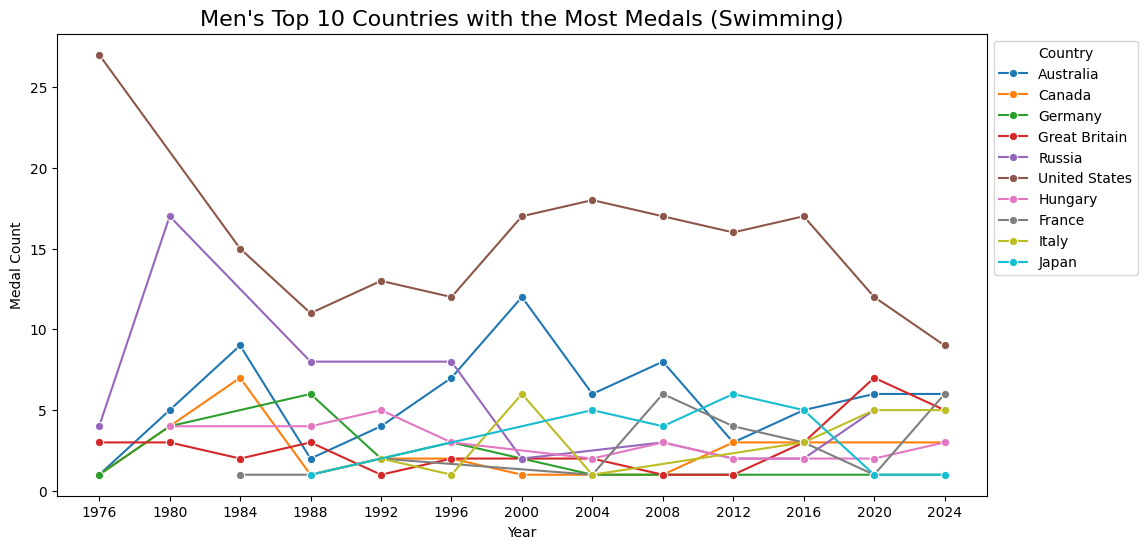

In [176]:
# plot the top 10 countries with the most medals over the years
plt.figure(figsize=(12, 6))
sns.lineplot(y='Medals', x='Year', data=men_top_ten_df, hue='Country', marker='o')
plt.title('Men\'s Top 10 Countries with the Most Medals (Swimming)', fontsize=16)
plt.legend(title='Country', bbox_to_anchor=(1, 1))
plt.ylabel('Medal Count')
plt.xticks(np.arange(1976, 2025, 4))
plt.show()

In [177]:
men_top_ten_df[men_top_ten_df['Country'] == 'Japan']

,Year,Country,Medals
23,1988,Japan,1
54,2004,Japan,5
62,2008,Japan,4
71,2012,Japan,6
79,2016,Japan,5
88,2020,Japan,1
98,2024,Japan,1


In [178]:
women_top_ten_df = top_ten_countries(women_swim_df)
women_top_ten_df.head()

,Year,Country,Medals
0,1976,Canada,7
1,1976,Germany,18
2,1976,Netherlands,2
3,1976,Russia,5
4,1976,United States,7


C:\Users\dagar\AppData\Local\Temp\ipykernel_31240\1415357752.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Cat_Event'] = df['Category'] + ' ' + df['Event']


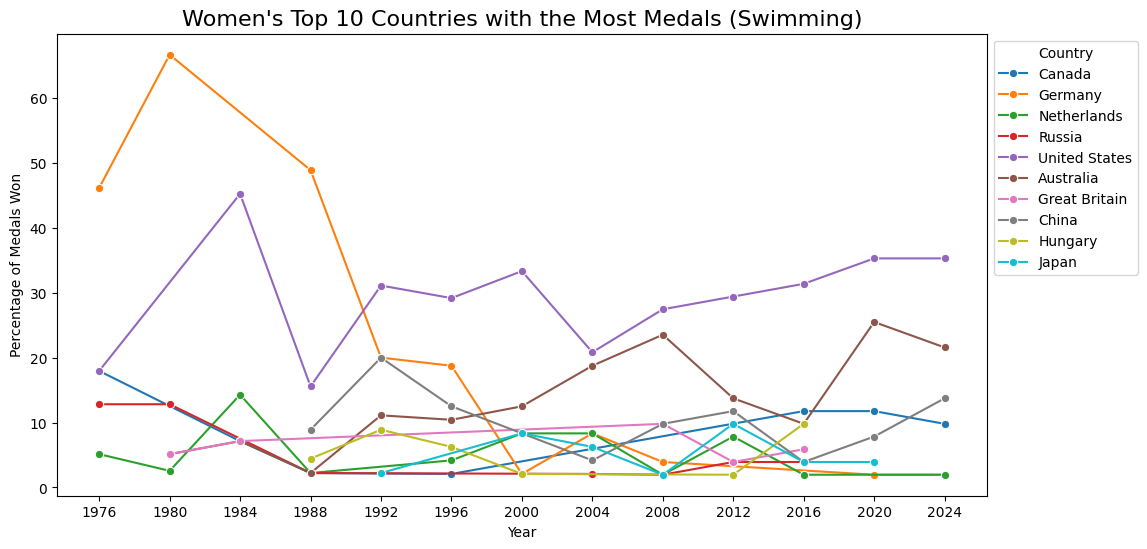

In [179]:
women_top_ten_df = top_ten_countries(women_swim_df)
potential_medals_df = get_potential_medals(women_swim_df)
women_pct_medals_df = get_pct_medals(women_top_ten_df, potential_medals_df)

# plot the top 10 countries with the most medals over the years
plt.figure(figsize=(12, 6))
sns.lineplot(y='Pct_Medals', x='Year', data=women_pct_medals_df, hue='Country', marker='o')
plt.title('Women\'s Top 10 Countries with the Most Medals (Swimming)', fontsize=16)
plt.xlabel('Year')
plt.ylabel('Percentage of Medals Won')
plt.xticks(np.arange(1976, 2025, 4))
plt.legend(title='Country', bbox_to_anchor=(1, 1))
plt.show()

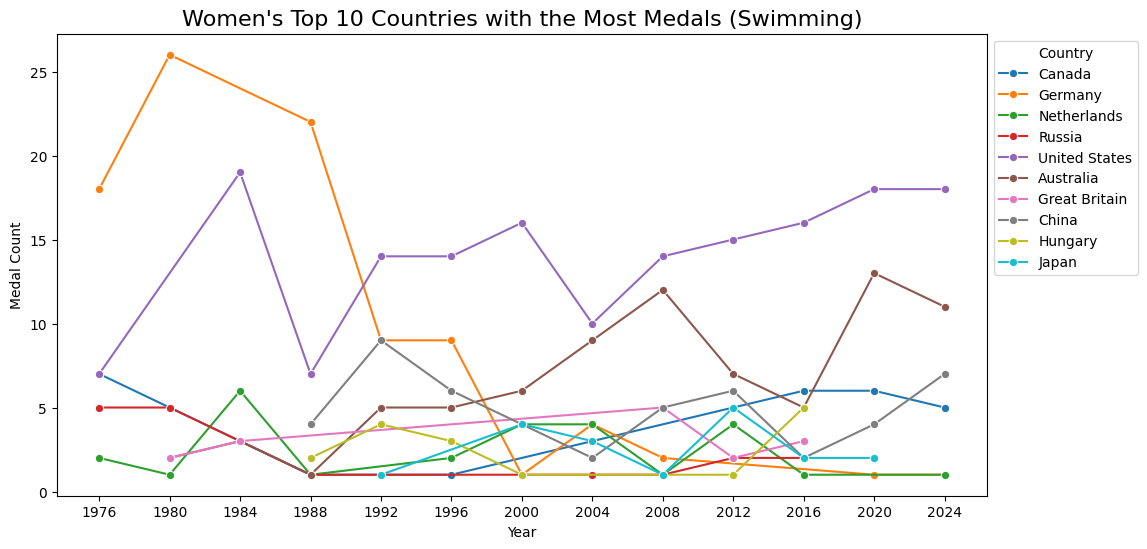

In [180]:
# plot the top 10 countries with the most medals over the years
plt.figure(figsize=(12, 6))
sns.lineplot(y='Medals', x='Year', data=women_top_ten_df, hue='Country', marker='o')
plt.title('Women\'s Top 10 Countries with the Most Medals (Swimming)', fontsize=16)
plt.xticks(np.arange(1976, 2025, 4))
plt.ylabel('Medal Count')
plt.legend(title='Country', bbox_to_anchor=(1, 1))
plt.show()

## USA Men's vs Women's Results

In [181]:
# create dataframes for the us men's and women's results
us_men_df = men_pct_medals_df.loc[men_pct_medals_df['Country'] == 'United States', :].copy()
us_women_df = women_pct_medals_df.loc[women_pct_medals_df['Country'] == 'United States', :].copy()
us_men_df['Category'] = 'Men'
us_women_df['Category'] = 'Women'

us_df = pd.concat([us_men_df, us_women_df])
us_df.head(), us_df.tail()

(    Year        Country  Medals  Events_Count  Potential_Medals  Pct_Medals  \
 5   1976  United States      27            13                39       69.23   
 15  1984  United States      15            15                45       33.33   
 25  1988  United States      11            16                48       22.92   
 33  1992  United States      13            16                48       27.08   
 41  1996  United States      12            16                48       25.00   
 
    Category  
 5       Men  
 15      Men  
 25      Men  
 33      Men  
 41      Men  ,
     Year        Country  Medals  Events_Count  Potential_Medals  Pct_Medals  \
 56  2008  United States      14            17                51       27.45   
 64  2012  United States      15            17                51       29.41   
 73  2016  United States      16            17                51       31.37   
 79  2020  United States      18            17                51       35.29   
 85  2024  United States   

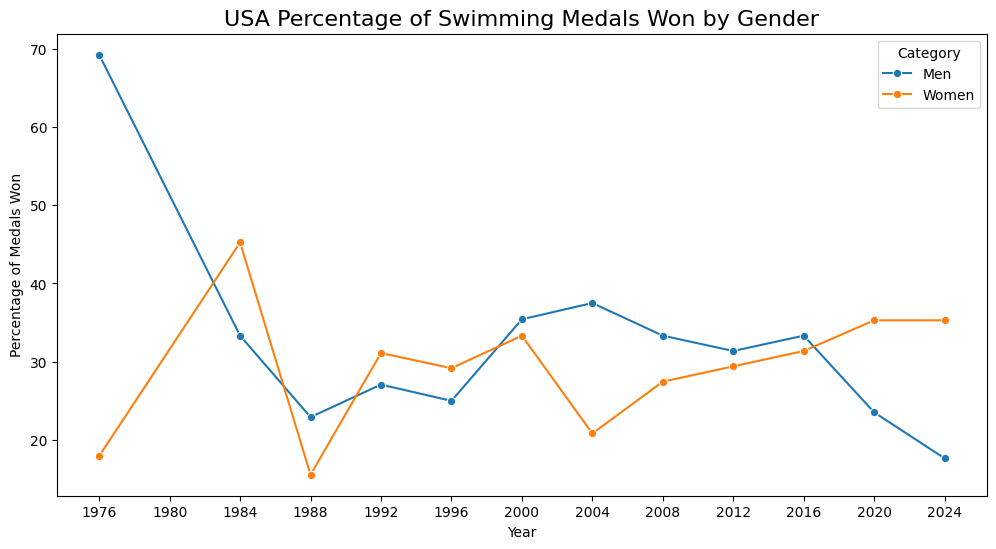

In [182]:
# plot the line for percentage of medals won by the US
plt.figure(figsize=(12, 6))
sns.lineplot(y='Pct_Medals', x='Year', data=us_df, hue='Category', marker='o')
plt.title('USA Percentage of Swimming Medals Won by Gender', fontsize=16)
plt.xlabel('Year')
plt.ylabel('Percentage of Medals Won')
plt.xticks(np.arange(1976, 2025, 4))
plt.legend(title='Category', bbox_to_anchor=(1, 1))
plt.show()

## Weighted Medal Results

In [183]:
recent_wt_medals_df = pct_weighted_medals(recent_swim_df)
top_ten_results = top_ten_countries(recent_wt_medals_df)
top_ten_wt_df = recent_wt_medals_df[recent_wt_medals_df['Country'].isin(top_ten_results['Country'].unique())]
top_ten_wt_df.head()

,Year,Country,Pct_Medal_Score
0,1976,Australia,0.006410
1,1976,Canada,0.064103
2,1976,Germany,0.301282
3,1976,Great Britain,0.038462
4,1976,Netherlands,0.012821


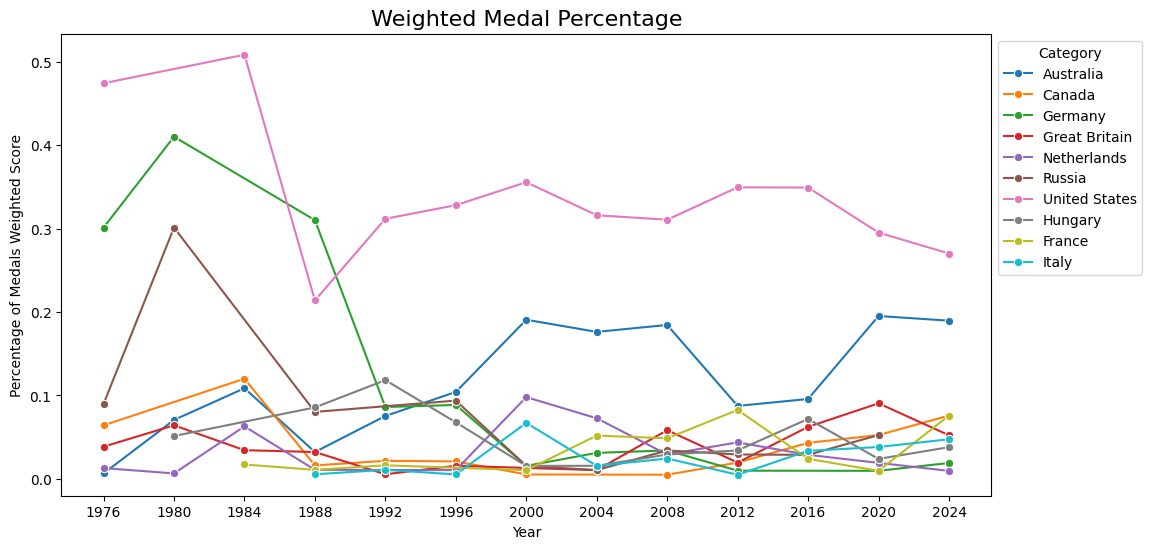

In [184]:
# plot the line for percentage of medals won by the US
plt.figure(figsize=(12, 6))
sns.lineplot(y='Pct_Medal_Score', x='Year', data=top_ten_wt_df, hue='Country', marker='o')
plt.title('Weighted Medal Percentage', fontsize=16)
plt.xlabel('Year')
plt.ylabel('Percentage of Medals Weighted Score')
plt.xticks(np.arange(1976, 2025, 4))
plt.legend(title='Category', bbox_to_anchor=(1, 1))
plt.show()

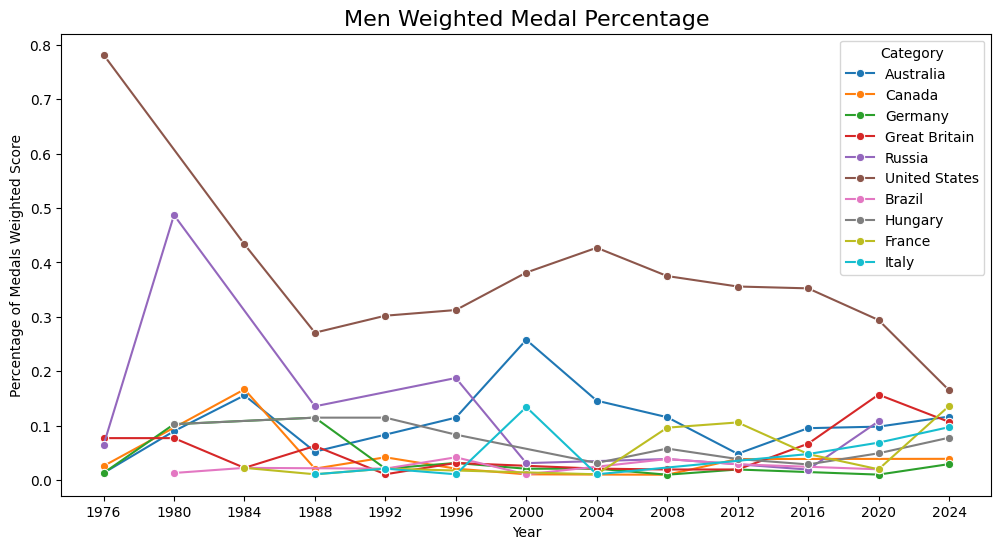

In [ ]:
men_recent_wt_medals_df = pct_weighted_medals(men_swim_df)
men_top_ten_results = top_ten_countries(men_recent_wt_medals_df)
men_top_ten_wt_df = men_recent_wt_medals_df[men_recent_wt_medals_df['Country'].isin(men_top_ten_results['Country'].unique())]

# plot the line for percentage of medals won by the US
plt.figure(figsize=(12, 6))
sns.lineplot(y='Pct_Medal_Score', x='Year', data=men_top_ten_wt_df, hue='Country', marker='o')
plt.title('Men Weighted Medal Score', fontsize=16)
plt.xlabel('Year')
plt.ylabel('Percentage of Medals Weighted Score')
plt.xticks(np.arange(1976, 2025, 4))
plt.legend(title='Category', bbox_to_anchor=(1, 1))
plt.show()

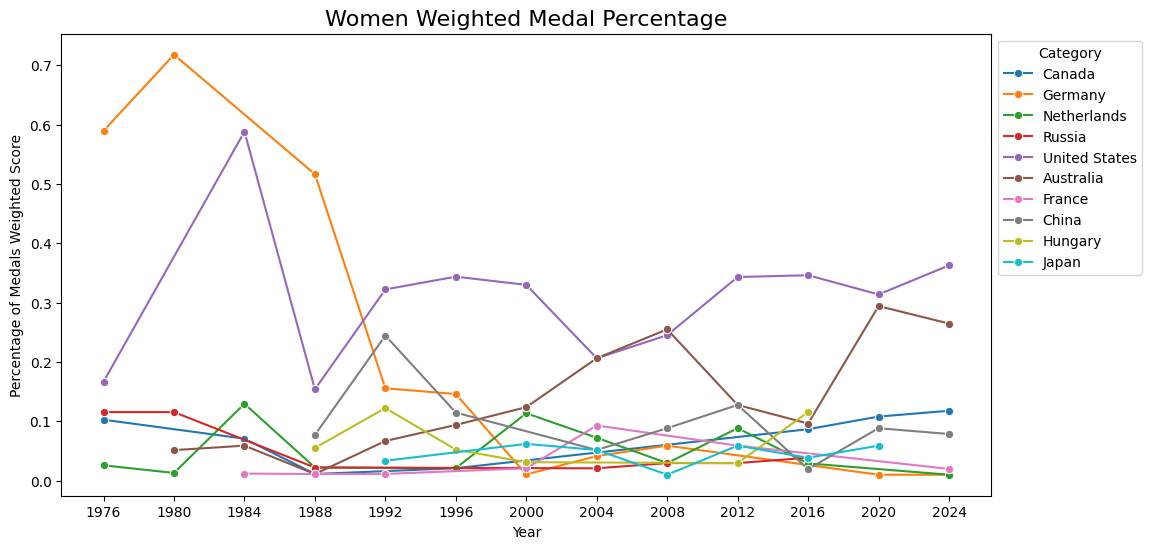

In [ ]:
women_recent_wt_medals_df = pct_weighted_medals(women_swim_df)
women_top_ten_results = top_ten_countries(women_recent_wt_medals_df)
women_top_ten_wt_df = women_recent_wt_medals_df[women_recent_wt_medals_df['Country'].isin(women_top_ten_results['Country'].unique())]

# plot the line for percentage of medals won by the US
plt.figure(figsize=(12, 6))
sns.lineplot(y='Pct_Medal_Score', x='Year', data=women_top_ten_wt_df, hue='Country', marker='o')
plt.title('Women Weighted Medal Score', fontsize=16)
plt.xlabel('Year')
plt.ylabel('Percentage of Medals Weighted Score')
plt.xticks(np.arange(1976, 2025, 4))
plt.legend(title='Category', bbox_to_anchor=(1, 1))
plt.show()